In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix,
    average_precision_score, precision_recall_curve, f1_score
)

# Imports pour le multiprocessing
import multiprocessing
from tqdm import tqdm

# --- NOTRE NOUVEL IMPORT ---
from src.periodogram import generate_periodogram

# Métrique Keras
pr_auc = tf.keras.metrics.AUC(curve='PR', name='pr_auc')

print("Bibliothèques importées.")

Bibliothèques importées.


In [2]:
print("Chargement et mélange des données brutes...")
train_df = pd.read_csv('../data/raw/train.csv')

X_raw = train_df.drop('LABEL', axis=1).values
y = train_df['LABEL'].values - 1  # (0, 1)

X_raw_shuffled, y_shuffled = shuffle(X_raw, y, random_state=42)

print(f"Forme de X_raw_shuffled : {X_raw_shuffled.shape}")
print(f"Forme de y_shuffled : {y_shuffled.shape}")

Chargement et mélange des données brutes...
Forme de X_raw_shuffled : (5087, 3197)
Forme de y_shuffled : (5087,)


In [3]:
# Cellule 3 : Pré-traitement (Génération des Périodogrammes)
# -----------------------------------------------------------------

N_BINS = 1000 # C'est notre nouvelle dimension : 1000 points de fréquence

X_data_to_process = X_raw_shuffled
y_data_to_process = y_shuffled

print(f"Démarrage de la génération des périodogrammes (vers {N_BINS} bins)...")

N_CORES = multiprocessing.cpu_count() - 1
if N_CORES < 1: N_CORES = 1
print(f"Utilisation de {N_CORES} cœurs CPU...")

# Préparer les arguments (row, n_bins)
func_args = [(row, N_BINS) for row in X_data_to_process]

with multiprocessing.Pool(processes=N_CORES) as pool:
    # On utilise starmap car notre fonction a 2 arguments
    X_periodogram = list(tqdm(pool.starmap(generate_periodogram, func_args), total=len(X_data_to_process)))

# Convertir en array numpy
X_periodogram = np.array(X_periodogram)
y = y_data_to_process

print("Génération des périodogrammes terminée !")
print(f"Forme de X_periodogram (nos nouvelles features) : {X_periodogram.shape}")

Démarrage de la génération des périodogrammes (vers 1000 bins)...
Utilisation de 7 cœurs CPU...


100%|██████████| 5087/5087 [00:00<00:00, 2445715.78it/s]

Génération des périodogrammes terminée !
Forme de X_periodogram (nos nouvelles features) : (5087, 1000)


In [4]:
print("Division des données (Train/Test)...")
X_train, X_test, y_train, y_test = train_test_split(
    X_periodogram, # <-- Nos nouvelles données
    y,             # <-- Nos labels
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Redimensionner pour le CNN
X_train_cnn = np.expand_dims(X_train, axis=-1)
X_test_cnn = np.expand_dims(X_test, axis=-1)

# Notre nouvelle forme d'entrée
INPUT_SHAPE = (N_BINS, 1) # (1000, 1)

print(f"Forme X_train_cnn : {X_train_cnn.shape}")
print(f"Forme X_test_cnn : {X_test_cnn.shape}")

Division des données (Train/Test)...
Forme X_train_cnn : (4069, 1000, 1)
Forme X_test_cnn : (1018, 1000, 1)


In [58]:
# Cellule 5 : Construction du Modèle (v17)

def build_periodogram_model(input_shape):
    model = tf.keras.models.Sequential(name="CNN_v17_Periodogram")

    model.add(tf.keras.layers.Input(shape=input_shape))

    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=7, activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=3))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=3))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=3))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

model = build_periodogram_model(INPUT_SHAPE)

# On compile avec notre LR stable (1e-4)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', pr_auc]
)

model.summary()

Model: "CNN_v17_Periodogram"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)              │ (None, 1000, 32)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 333, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 333, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 333, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 111, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 111, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 111, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 37, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 37, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 4736)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │       303,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 338,497 (1.29 MB)

 Trainable params: 338,497 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Cellule 5b : Calculer les Poids de Classe
# ----------------------------------------
weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {0: weights[0], 1: weights[1]}

print(f"Poids de classe (0: 'Pas Planète'): {weights[0]:.2f}")
print(f"Poids de classe (1: 'Planète'):   {weights[1]:.2f}")

Poids de classe (Classe 0 'Pas Planète'): 1.00
Poids de classe (Classe 1 'Planète'):   40.00


In [61]:
# Cellule 6 : Callbacks et Entraînement (v21 - Stable)
# ----------------------------------------------------------------

LOG_DIR = './logs/v21_periodogram_stable'
MODEL_PATH = '../models/cnn_v21_periodogram_best.h5'

!rmdir /S /Q .\\logs\\v21_periodogram_stable

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq=1)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_PATH, save_best_only=True,
    monitor='val_pr_auc', mode='max', verbose=1
)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_pr_auc',
    mode='max',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Entraînement
print(f"Début de l'entraînement (v21 - Stable : LR=1e-4, Poids=67, Batch=64)...")
history = model.fit(
    X_train_cnn,
    y_train,
    epochs=100,
    batch_size=64, # <-- CHANGEMENT : Batch plus grand pour stabiliser
    validation_data=(X_test_cnn, y_test),
    callbacks=[tensorboard_cb, checkpoint_cb, early_stopping_cb],
    class_weight=class_weights_dict # ON GARDE LES POIDS 'balanced'
)

Début de l'entraînement (v22 - Poids 40:1, Batch=64)...
Epoch 1/100


Le fichier sp‚cifi‚ est introuvable.


63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9460 - loss: 0.8125 - pr_auc: 0.0102
Epoch 1: val_pr_auc improved from None to 0.15813, saving model to ../models/cnn_v22_periodogram_best.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9801 - loss: 0.6939 - pr_auc: 0.0092 - val_accuracy: 0.9931 - val_loss: 0.3587 - val_pr_auc: 0.1581
Epoch 2/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9890 - loss: 0.5791 - pr_auc: 0.0104
Epoch 2: val_pr_auc did not improve from 0.15813
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9737 - loss: 0.6610 - pr_auc: 0.0138 - val_accuracy: 0.9931 - val_loss: 0.4495 - val_pr_auc: 0.0952
Epoch 3/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9812 - loss: 0.6967 - pr_auc: 0.0146
Epoch 3: val_pr_auc did not improve from 0.15813
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9717 - loss: 0.6829 - pr_auc: 0.0118 - val_accuracy: 0.9106 - val_loss: 0.4757 - val_pr_auc: 0.0220
Epoch 4/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9742 - loss: 0.7289 - pr_auc: 0.0127
Epoch 4: val_pr_auc did not improve from 0.15813
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9786 - loss: 0.6771 - pr_auc

In [62]:
# Cellule 7 : Évaluation (Seuil 0.5 vs. Optimisé) (v17)
# ----------------------------------------------------
# (Assurez-vous que 'average_precision_score', 'precision_recall_curve',
# 'f1_score' sont importés depuis la Cellule 1)

print("Évaluation du meilleur modèle v17 (restauré de l'époque 56)...")

# Prédictions (une seule fois)
y_pred_proba = model.predict(X_test_cnn).ravel()

# --- 1. Évaluation avec Seuil 0.5 ---
print("\n" + "="*40)
print("ÉVALUATION AVEC SEUIL 0.5")
print("="*40)
y_pred_class_05 = (y_pred_proba > 0.5).astype(int)

print("\n--- Rapport (Seuil 0.5) ---")
print(classification_report(y_test, y_pred_class_05, target_names=['Pas Planète', 'Planète'], zero_division=0))
print("\n--- Matrice (Seuil 0.5) ---")
print(confusion_matrix(y_test, y_pred_class_05))

# --- 2. Évaluation avec Seuil Optimisé ---
print("\n" + "="*40)
print("ÉVALUATION AVEC SEUIL OPTIMISÉ")
print("="*40)

# 2a. Calculer la courbe P-R
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# 2b. Trouver le meilleur F1-Score
f1_scores = (2 * precision * recall) / (precision + recall + 1e-9)
best_f1_index = np.argmax(f1_scores)
best_f1 = f1_scores[best_f1_index]
best_threshold = thresholds[best_f1_index]

print(f"\nMeilleur F1-Score trouvé : {best_f1:.4f}")
print(f"Au Seuil optimal de : {best_threshold:.4f}")

# 2c. Évaluer avec CE SEUIL
y_pred_class_optimal = (y_pred_proba > best_threshold).astype(int)

print("\n--- Rapport (Seuil Optimisé) ---")
print(classification_report(y_test, y_pred_class_optimal, target_names=['Pas Planète', 'Planète'], zero_division=0))
print("\n--- Matrice (Seuil Optimisé) ---")
print(confusion_matrix(y_test, y_pred_class_optimal))

# --- 3. Score Global (Indépendant du seuil) ---
pr_auc_score = average_precision_score(y_test, y_pred_proba)
print(f"\nScore PR-AUC global (Average Precision) : {pr_auc_score:.4f}")

Évaluation du meilleur modèle v17 (restauré de l'époque 56)...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

ÉVALUATION AVEC SEUIL 0.5

--- Rapport (Seuil 0.5) ---
              precision    recall  f1-score   support

 Pas Planète       0.99      1.00      1.00      1011
     Planète       0.00      0.00      0.00         7

    accuracy                           0.99      1018
   macro avg       0.50      0.50      0.50      1018
weighted avg       0.99      0.99      0.99      1018


--- Matrice (Seuil 0.5) ---
[[1011    0]
 [   7    0]]

ÉVALUATION AVEC SEUIL OPTIMISÉ

Meilleur F1-Score trouvé : 0.2500
Au Seuil optimal de : 0.4053

--- Rapport (Seuil Optimisé) ---
              precision    recall  f1-score   support

 Pas Planète       0.99      1.00      1.00      1011
     Planète       0.00      0.00      0.00         7

    accuracy                           0.99      1018
   macro avg       0.50      0.50      0.50      1018
weighted avg       0.99      0.99      0.99      1018




Affichage des graphiques d'entraînement (v17)...


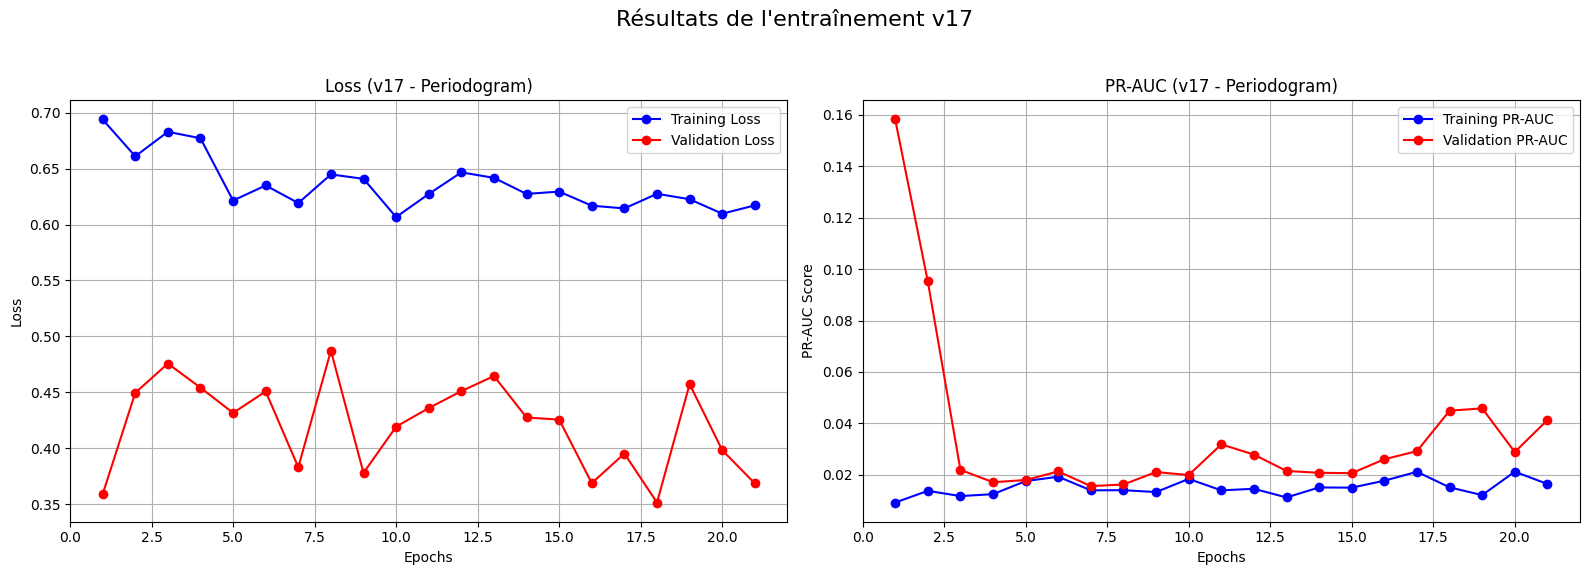

In [63]:
# Cellule 8 : Visualisation des résultats (v17)
# ----------------------------------------------

print("Affichage des graphiques d'entraînement (v17)...")
history_dict = history.history

# Récupérer les métriques
loss = history_dict['loss']
val_loss = history_dict['val_loss']
pr_auc = history_dict['pr_auc']
val_pr_auc = history_dict['val_pr_auc']

# Créer la plage d'époques
actual_epochs = len(loss)
epochs_range = range(1, actual_epochs + 1)

# Créer la figure
plt.figure(figsize=(16, 6))

# Graphique 1 : Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title('Loss (v17 - Periodogram)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Graphique 2 : PR-AUC
plt.subplot(1, 2, 2)
plt.plot(epochs_range, pr_auc, 'bo-', label='Training PR-AUC')
plt.plot(epochs_range, val_pr_auc, 'ro-', label='Validation PR-AUC')
plt.title('PR-AUC (v17 - Periodogram)')
plt.xlabel('Epochs')
plt.ylabel('PR-AUC Score')
plt.legend()
plt.grid(True)

plt.suptitle("Résultats de l'entraînement v17", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()